# Методы семейства «актор-критик». ДЗ 3 (vo_HW)

In [4]:
import os
import gym
import numpy as np
from utils import plot_learning_curve
from agents import Agent

In [5]:
env_name = 'InvertedDoublePendulum-v4'#'HalfCheetah-v2'#'HalfCheetahBulletEnv-v0'
dir = 'tmp'
n_games = 1000


gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
memory_size = 1000000
batch_size = 256
tau = 0.005
update_period = 2
reward_scale = 2.
warmup = 1000
reparam_noise_lim = 1e-6
play = False
load_checkpoint = False
gpu_to_cpu = False


## Run SAC

/home/danil/Projects/rl_hw3/.venv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


step: 8
| Game:      0 | Score:      73.07 | Best score:       -inf | Avg score      73.07 | Learning inter:          8 |
step: 7
| Game:      1 | Score:      63.89 | Best score:      73.07 | Avg score      68.48 | Learning inter:         15 |
step: 6
| Game:      2 | Score:      54.97 | Best score:      73.07 | Avg score      63.98 | Learning inter:         21 |
step: 11
| Game:      3 | Score:     101.27 | Best score:      73.07 | Avg score      73.30 | Learning inter:         32 |
step: 8
| Game:      4 | Score:      73.43 | Best score:      73.30 | Avg score      73.33 | Learning inter:         40 |
step: 13
| Game:      5 | Score:     120.11 | Best score:      73.33 | Avg score      81.12 | Learning inter:         53 |
step: 7
| Game:      6 | Score:      64.03 | Best score:      81.12 | Avg score      78.68 | Learning inter:         60 |
step: 8
| Game:      7 | Score:      73.65 | Best score:      81.12 | Avg score      78.05 | Learning inter:         68 |
step: 10
| Game:      

/home/danil/Projects/rl_hw3/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/danil/Projects/rl_hw3/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


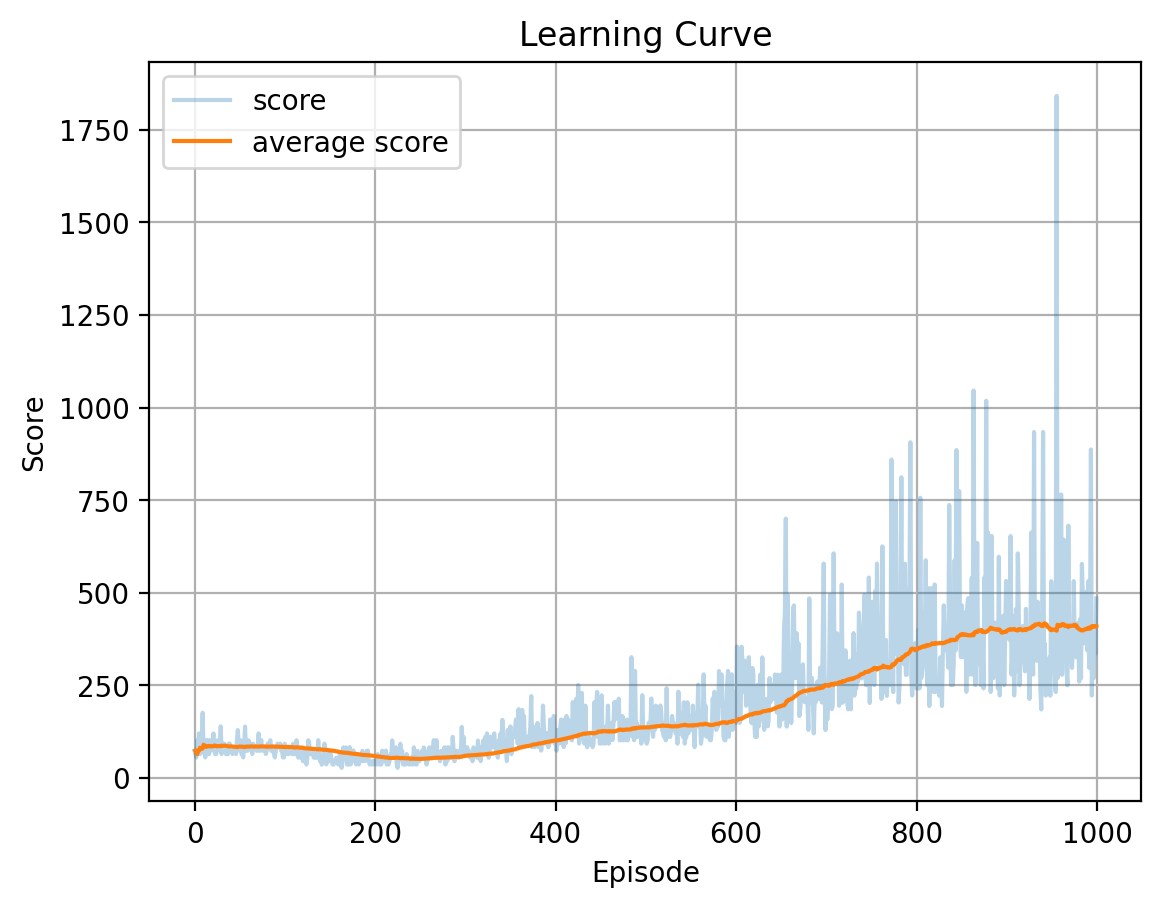

In [6]:
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

agent = Agent(gamma=gamma, alpha=alpha, beta=beta, state_dims=env.observation_space.shape,
              action_dims=env.action_space.shape, max_action=env.action_space.high[0],
              fc1_dim=fc1_dim, fc2_dim=fc2_dim, memory_size=memory_size,
              batch_size=batch_size, tau=tau, update_period=update_period,
              reward_scale=reward_scale, warmup=warmup, reparam_noise_lim=reparam_noise_lim,
              name='SAC_'+env_name, ckpt_dir=dir_path)

scores, avg_scores = [], []
best_score = -np.inf

if play:
    env.render(mode='human') # (cannot render in colab)
    # pass

if load_checkpoint:
    agent.load_model(gpu_to_cpu=gpu_to_cpu)

for game in range(n_games):
    observation, _ = env.reset()
    done = False
    score = 0

    step = 0
    while not done:
        if play:
            action = agent.choose_action(observation, deterministic=True, reparameterize=False)
        else:
            action = agent.choose_action(observation, deterministic=False, reparameterize=False)
        observation_, reward, done, _, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        if not play:
            agent.learn()
        observation = observation_
        step += 1
    print('step:',step)
    
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning inter: {agent.learn_iter:10.0f} |')

    if avg_score > best_score:
        best_score = avg_score
        if not play:
            agent.save_model()
env.close()

if not play:
    plot_learning_curve(scores, agent.full_path)
